# Min-wise locality sensitive hashing task

## By Nikhil Saldanha(4998707)

In [1]:
from collections import defaultdict

In [2]:
from tqdm import tqdm

from itertools import permutations

import pandas as pd

from nltk import ngrams

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import numpy as np

import matplotlib.pyplot as plt

from math import ceil, log2
from primesieve import nth_prime
from random import randint

In [3]:
df = pd.read_csv("data/TotBytes_Dur_discretized.csv")

## We One-Hot Encode to get binarized ngram

_Since according to the question_

"For this task, the profiles are binary, an N-gram (subsequence) exists (a 1 in the table) or does not (a 0 in the table)"

In [4]:
ohe_dfs = []
for (src, dst), indexes in df[["SrcAddr", "DstAddr", "TotBytes_Dur"]].groupby(["SrcAddr", "DstAddr"]).groups.items():
    group_df = df.loc[indexes]
    ng = set(ngrams(group_df["TotBytes_Dur"], 3))
    ng = list(map(str, ng))
    ohe_df = pd.get_dummies(pd.Series(ng))
    # ohe_df = ohe_df.assign(SrcAddr=src, DstAddr=dst)
    ohe_dfs.append(ohe_df)

<ipython-input-4-9d708b59720f>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ohe_df = pd.get_dummies(pd.Series(ng))


We fill NaNs with 0 (where the ngram did not occur)

In [5]:
profile_df = pd.concat(ohe_dfs).fillna(0)

In [6]:
profile_df

,"(3.0, 3.0, 3.0)","(8.0, 3.0, 3.0)","(3.0, 3.0, 8.0)","(3.0, 8.0, 3.0)","(8.0, 3.0, 8.0)","(8.0, 8.0, 3.0)","(8.0, 8.0, 8.0)","(13.0, 8.0, 3.0)","(3.0, 13.0, 8.0)","(8.0, 3.0, 13.0)",...,"(8.0, 16.0, 12.0)","(4.0, 7.0, 3.0)","(9.0, 4.0, 7.0)","(7.0, 9.0, 9.0)","(9.0, 7.0, 9.0)","(12.0, 12.0, 14.0)","(12.0, 14.0, 14.0)","(14.0, 14.0, 12.0)","(2.0, 4.0, 2.0)","(4.0, 2.0, 4.0)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We create a table with each row as the profile of a host, which is comprized of the one-hot encoded ngrams. Computing similarity between rows should give us similarity between hosts

In [7]:
profile = profile_df.to_numpy()

# Transpose profile to have hosts as the columns

The minwise lsh algorithm is defined as a similarity between column. So, we transpose the above table to be able to use this algorithm

In [8]:
profile = profile.T

### Create permutations of all possible pairs of IPs

In [9]:
# create permutations
perm = list(permutations([i for i in range(profile.shape[1])], 2))

## Jaccard Similarity of columns

Before we compute the min-wise LSH to get a faster computation of similarity between hosts. We perform jaccard similarity between the host profiles as a baseline. This metric should be very accurate but it is quite expensive to perform as it involves comparison between every ngram.

### Note: this can take about 4-5 minutes

In [14]:
def jaccard_sim(perm, profile):
    jacc = []
    
    for p in tqdm(perm):
        p1 = np.asarray(profile[:, p[0]], np.bool)
        p2 = np.asarray(profile[:, p[1]], np.bool)
        j = np.double(np.bitwise_and(p1, p2).sum()) / np.double(np.bitwise_or(p1, p2).sum())
        jacc.append(j)
    return np.array(jacc)

In [15]:
jacc = jaccard_sim(perm, profile)

100%|██████████| 3970056/3970056 [03:02<00:00, 21704.81it/s]


We see that this takes quite a long time to compute the similarity as it compares every ngram between pairs of profiles. Let us compare this with the time taken to compute the signature similarity(which we compute later). We expect jaccard similarity to take much more time.

## Universal Hashing

This is a method of constructing a hash function by selecting a hash function at random from a family of hash functions with a certain mathematical property. This guarantees a low number of collisions in expectation. We compute the hash here by the mathematical property of having a certain remainder(equal to number of buckets) after division of a polynomial by a large prime number. This ensures that there are few candidates in the same bucket.

In [16]:
class UniversalHashing:
    """
    N = #bins
    p = prime number st: p >= N
    """
    def __init__(self, N, p = None):
        self.N = N
        if p is None:
            p = nth_prime(1, 1 << max(32, ceil(log2(N))))
        assert p >= N, 'Prime number p should be at least N!'
        self.p = p

    def draw(self):
        a = randint(1, self.p - 1)
        b = randint(0, self.p - 1)
        return lambda x: ((a * x + b) % self.p) % self.N

## Minwise Locality Sensitive Hashing

We hash the profiles using minwise lsh to a reduced space. The hope is that the properties of jaccard similarity is preserved in this reduced space. Hence allowing us to compute distances much faster.

In [17]:
def compute_minwise_lsh(profile, bins):
    num_hash_fns = 100
    H = UniversalHashing(bins)
    hash_fns = []
    for i in range(num_hash_fns):
        hash_fns.append(H.draw())
    h = defaultdict(dict)
    M = np.full([num_hash_fns, profile.shape[1]], np.inf)
    for r in range(profile.shape[0]):
        # compute hash values
        for i, h_i in enumerate(hash_fns):
            # compute h_i(profile[r])
            h[i][r] = h_i(r)
        for c in range(profile.shape[1]):
            if profile[r, c] == 1:
                for i in range(num_hash_fns):
                    if h[i][r] < M[i, c]:
                        M[i, c] = h[i][r]
    return M

In [22]:
(np.array([1, 2, 3]) == np.array([3, 2, 1])).sum()

1

In [23]:
def signature_sim(perm, M):
    sig_sim = []
    for p in tqdm(perm):
        p1 = M[:, p[0]]
        p2 = M[:, p[1]]

        tot = M.shape[0]
        sim = (p1 == p2).sum()
        sig_sim.append(sim/tot)
    return sig_sim

## Signature Similarity

We compute the minwise lsh for the profile of each ip pair to get a signature matrix M which should hash similar profiles together. We test out the minwise lsh with 100 hash functions generated via universal hashing. We would like to see the effect of varying the number of bins on the accuracy of the similarity metric with respect to the jaccard similarity.

To do this, we compute a mean sum of squares error between the jaccard similarity and the signature similarity computed via the hashes.

We expect that the similarity scores will tend toward the jaccard similarity as the number of bins are increased, approximating a better score.

In [24]:
bins = [10, 20, 50, 100]
sig_sims = []
for b in bins:
    M = compute_minwise_lsh(profile, b)
    sig_sim = np.array(signature_sim(perm, M))
    sig_sims.append(sig_sim)

100%|██████████| 3970056/3970056 [01:20<00:00, 49171.62it/s]


We notice that each similarity computation takes about 1.5 minutes while, if we recall, jaccard similarity took about 4 minutes. This is a large speedup in terms of performance due to the fact that we have a reduced space due to hashing.

In [25]:
import math

### Compute Error of estimation

In [26]:
errors = []
for sig_sim in sig_sims:
    error = [math.sqrt((s - j)**2) for s, j in zip(sig_sim, jacc)]
    errors.append(sum(error)/len(error))

Text(0, 0.5, 'error in signature similarity(as compared to jaccard similarity)')

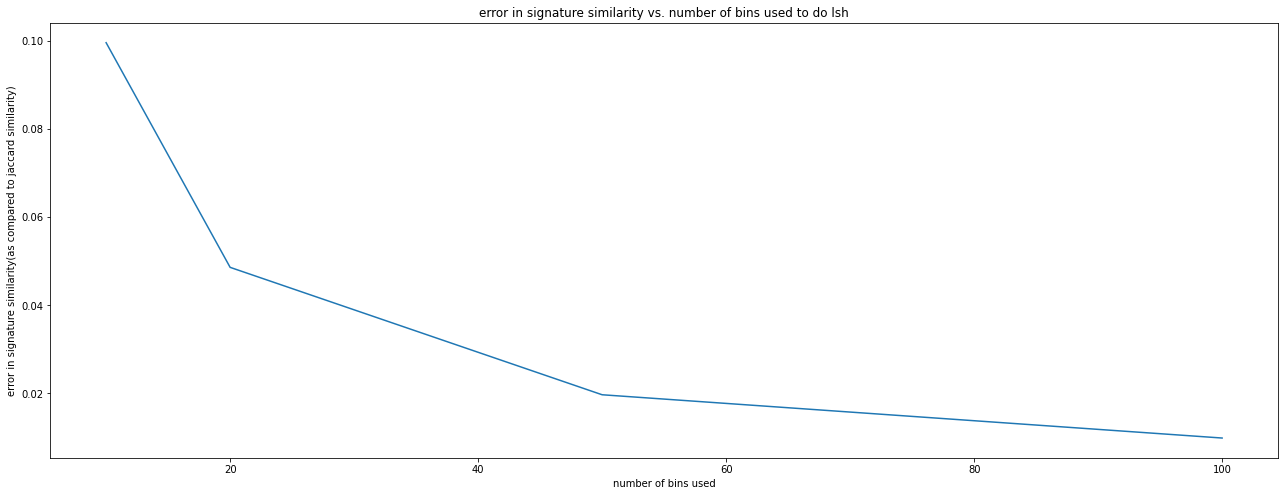

In [27]:
f, ax = plt.subplots(1, 1, figsize =(22, 8))
ax.plot(bins, errors)
ax.set_title("error in signature similarity vs. number of bins used to do lsh")
ax.set_xlabel("number of bins used")
ax.set_ylabel("error in signature similarity(as compared to jaccard similarity)")

We see that the error follows the expected downward trend as trend as the bins are increased. After 50 bins, the reduction in error is not that much and so we could say that 50 is a reasonable amount of bins